首先来找点数据:
# 美国货物进口总额与海关关税收入数据获取指南

## 一、Total U.S. Imports of Goods (美国货物进口总额) 数据获取

### 方法1：通过FRED(Federal Reserve Economic Data)下载

1. **访问FRED网站**：https://fred.stlouisfed.org/
2. 在搜索框中输入：`Imports of Goods for United States`
3. 在搜索结果中找到名为"Imports of Goods for United States (IMPTOTUS)"的系列 
   - **频率**：月度(Monthly)
   - **单位**：百万美元(Millions of Dollars)，未季节调整(Not Seasonally Adjusted)
   - **来源**：U.S. Census Bureau
4. 点击该系列进入详情页，页面右上角有"Download"按钮，可选择以下格式下载 ：
   - **Excel (.xlsx)**：适合使用Microsoft Excel分析
   - **CSV (.csv)**：适合使用其他数据分析软件

### 方法2：直接访问FRED数据页面下载

直接访问以下URL，可查看并下载数据 ：
https://fred.stlouisfed.org/series/IMPTOTUS

**数据特点**：
- 时间范围：2008年1月至今 
- 最新数据(2025年7月)：292,244.90百万美元(约2,922亿美元) 

## 二、Customs Duties (海关关税收入) 数据获取

### 方法1：通过美国财政部(Department of Treasury)的Monthly Treasury Statement获取

1. 访问财政部Monthly Treasury Statement页面：https://fiscal.treasury.gov/reports-statements/mts/current.html 
2. 下载最新月度报告(PDF或Excel格式)
3. 在报告中查找"Customs Duties"(海关关税)或"Net Customs Receipts"(净海关收入)项目 

### 方法2：通过USITC的DataWeb平台获取

1. 访问USITC的DataWeb网站：https://dataweb.usitc.gov/ 
2. 点击"New Data Request"创建新的数据请求 
3. 在"Trade Flow"部分选择"Imports: For Consumption"
4. 在"Data to Report"部分勾选"Collected Duties"(已收关税)和"Value of Imports"(进口价值)
5. 选择时间范围(月度)，点击"Continue"
6. 在下一页选择所需的分类系统(如HTS编码)，点击"Continue"
7. 生成报告后，点击"Download"下载Excel或CSV格式数据 

### 方法3：直接访问USITC关税数据统计表

USITC提供历史关税数据统计表，包含1891-2021年的年度和月度数据：
https://www.usitc.gov/documents/dataweb/ave_table_1891_2021.pdf 

## 三、数据使用建议

1. **数据匹配**：将货物进口总额与关税收入数据结合，可以计算平均关税率(关税收入÷进口总额) 

2. **最新数据参考**：
   - 2025年8月美国关税收入达314亿美元，创历史新高 
   - 2025财年前8个月(截至8月)累计关税收入超2,149亿美元 

## 四、注意事项

- **数据来源差异**：关税收入数据在财政部报表中称为"Customs Duties"，在USITC中称为"Collected Duties"，两者数值基本一致，但财政部数据已扣除退税和退款 

- **数据完整性**：
  - FRED的货物进口数据始于2008年
  - USITC的关税数据可追溯至19世纪末 

- **更新频率**：
  - 月度数据通常在次月中旬发布
  - 建议定期检查官方网站获取最新更新

**总结**：通过上述方法，您可以方便地获取美国货物进口总额和海关关税收入的月度数据。FRED提供了简洁的数据下载界面，而USITC的DataWeb则提供了更灵活的数据筛选和定制功能。若需长期跟踪分析，建议同时使用这两个数据源以相互验证。

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
df_imports.head()

# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS'])
# plt.xlabel('Month')
# plt.ylabel('Imports (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()

# df_imports['IMPTOTUS_DIFF'] = df_imports['IMPTOTUS'].astype(float).diff()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()
# print(df_imports['IMPTOTUS_DIFF'].mean(), df_imports['IMPTOTUS_DIFF'].std())

# df_imports['IMPTOTUS_std']= df_imports['IMPTOTUS_DIFF'].astype(float).rolling(window=5,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_std'])
# plt.xlabel('Month')
# plt.title('Imports of United States')
# plt.show()

,observation_date,IMPTOTUS
0,2008-01-01,168350.2
1,2008-02-01,165069.7
2,2008-03-01,171194.0
3,2008-04-01,182115.1
4,2008-05-01,182956.3


(开始尝试一下最简单的时间序列分析)这个直接使用AI编程就行了

尝试探索一下第一次关税战的对进口额的影响


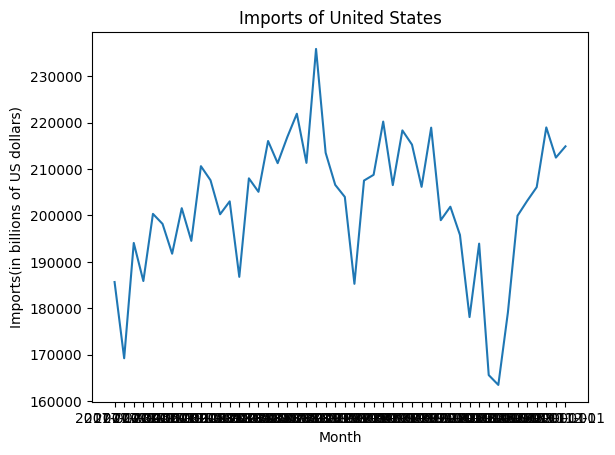

205149.11823366824 41950.76573690996


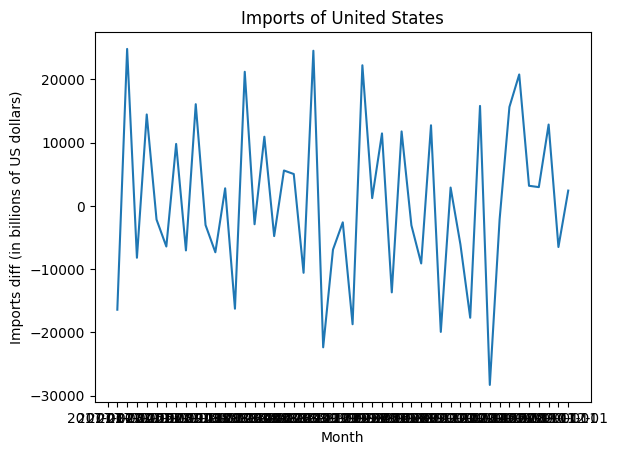

621.7671461063834 13299.059164504264


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_imports = pd.read_csv(r'..\..\data\raw\Q4\IMPTOTUS.csv')
# df_imports['observation_date'] = pd.to_datetime(df_imports['observation_date'])
df_imports.set_index('observation_date', inplace=True)
df_imports.head()

df_imports_2017_2020=df_imports.loc["2017-01-01":"2020-12-01"].copy()
df_imports_2017_2020.head()
df_imports_2017_2020.to_csv(r'..\..\data\processed\Q4_IMPTOTUS_2017_2020.csv', index=True)


plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS'])
plt.xlabel('Month')
plt.ylabel('Imports(in billions of US dollars)')
plt.title('Imports of United States')
plt.show()
print(df_imports['IMPTOTUS'].mean(), df_imports['IMPTOTUS'].std())


df_imports_2017_2020['IMPTOTUS_DIFF'] = df_imports_2017_2020['IMPTOTUS'].diff()
plt.plot(df_imports_2017_2020.index,df_imports_2017_2020['IMPTOTUS_DIFF'])
plt.xlabel('Month')
plt.ylabel('Imports diff (in billions of US dollars)')
plt.title('Imports of United States')
plt.show()
print(df_imports_2017_2020['IMPTOTUS_DIFF'].mean(), df_imports_2017_2020['IMPTOTUS_DIFF'].std())

# df_imports['IMPTOTUS_DIFF_STD'] = df_imports.rolling(window=12,min_periods=1).std()
# plt.plot(df_imports['observation_date'],df_imports['IMPTOTUS_DIFF_STD'])
# plt.xlabel('Month')
# plt.ylabel('Imports diff STD (in billions of US dollars)')
# plt.title('Imports of United States')
# plt.show()